In [1]:
import matplotlib.pyplot as plt

import torch

from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset

from glow import GLOW

import normflows as nf

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    nf.utils.Scale(255. / 256.), 
    nf.utils.Jitter(1 / 256.)
])

train_data = CIFAR10(root='./data', train=True, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)
flow = GLOW(3, 16, (3, 32, 32), 10, 256)

In [3]:
flow.model.load_state_dict(torch.load('glow_cifar.pt', map_location='cpu'))

C:\Users\luana\AppData\Local\Temp\ipykernel_36424\4117871043.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.model.load_state_dict(torch.load('glow_cifar.pt', map_l

<All keys matched successfully>

c:\Users\luana\Documents\lime\glow.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.046963215..1.0474066].


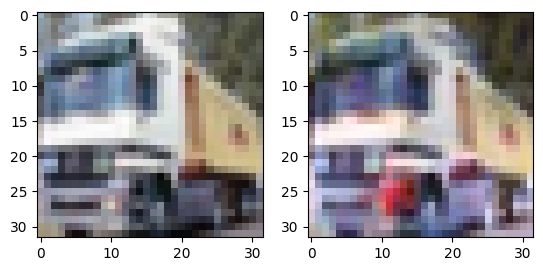

In [4]:
sample = train_data[1][0].unsqueeze(0)
latent = flow.to_latent(sample)
latent[0] = latent[0] + torch.randn_like(latent[0]) * 0.6
reconstructed = flow.to_image(latent)

plt.subplot(1, 2, 1)
plt.imshow(sample.squeeze().detach().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(reconstructed[0].squeeze().detach().numpy().transpose(1, 2, 0))
plt.show()

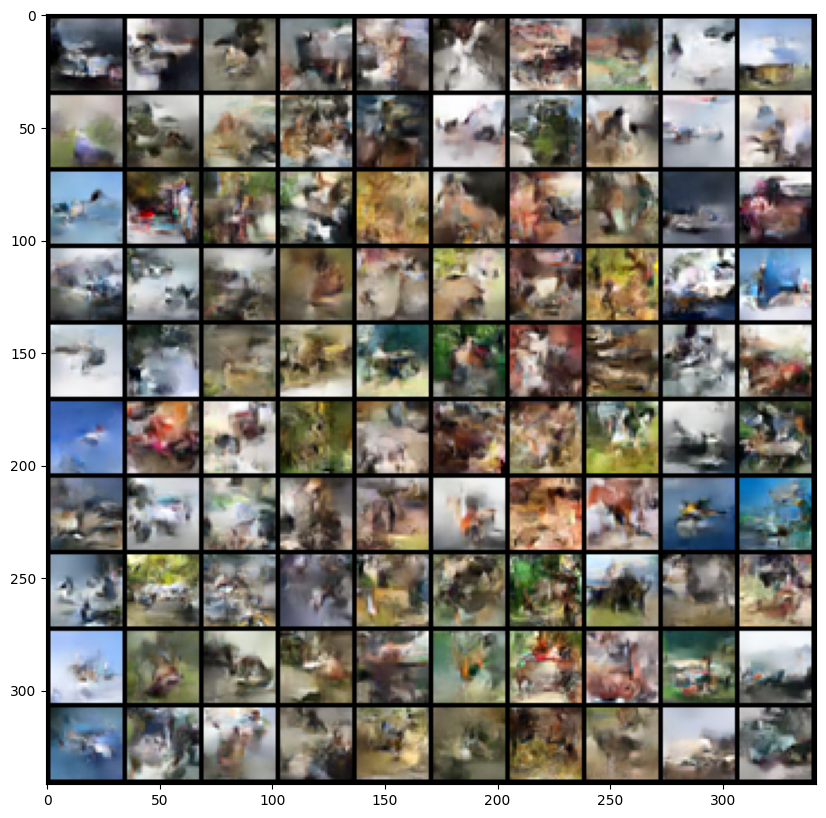

In [90]:
import torchvision as tv
import numpy as np
num_sample = 10

with torch.no_grad():
    y = torch.arange(10).repeat(num_sample)
    x, _ = flow.model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=10).cpu().numpy(), (1, 2, 0)))
    plt.show()

(32, 32, 3) (32, 32, 3)


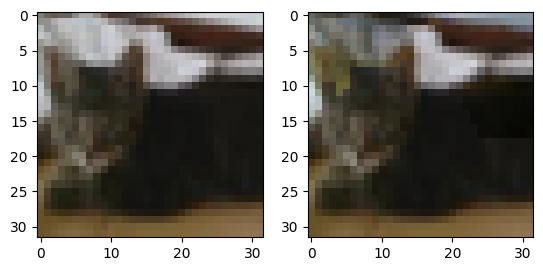

In [89]:
from lime import FlowSampler

from skimage.segmentation import slic, mark_boundaries

input_image = train_data[9][0].numpy().transpose(1, 2, 0)

# plot mask
segments = slic(input_image, n_segments=15, compactness=10)
instance = np.asarray(input_image)

sampler = FlowSampler(flow, segments, )
plt.subplot(1, 2, 1)
plt.imshow(instance)
plt.subplot(1, 2, 2)
plt.imshow(sampler.sample(instance, 1)[0][0])
plt.show()